In [1]:
using Revise, ReachabilityAnalysis, Plots, LazySets

@taylorize function benchmark7!(du, u, p, t)
    local two = 2.0+zero(u[1])
    du[1] = u[3]^3 - u[2] + u[4]
    du[2] = u[3]
    du[3] = two
    du[4] = zero(u[4])
    return du
end

# define the initial-value problem
X₀ = Hyperrectangle(low=[0.35, 0.45, 0.25, -0.01], high=[0.45, 0.55, 0.35, 0.01])

prob = @ivp(x' = benchmark7!(x), dim: 4, x(0) ∈ X₀)

# solve it
sol = solve(prob, T=0.5);

In [2]:
sol = overapproximate(sol, Zonotope);

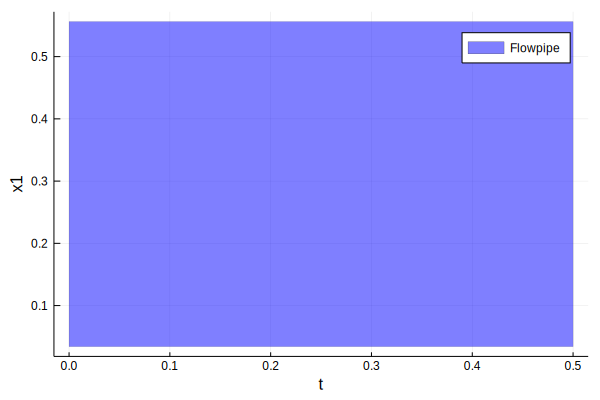

In [3]:
plot(sol, vars=(0, 1), xlab="t", ylab="x1", lw=0.2, color=:blue, lab="Flowpipe")

In [4]:
using NeuralVerification, JLD2

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1260
┌ Warning: Replacing docs for `LazySets.HPolytope :: Union{Tuple{Union{Polyhedra.HRepresentation{N}, Polyhedra.Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `LazySets.HPolyhedron :: Union{Tuple{Union{Polyhedra.HRepresentation{N}, Polyhedra.Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{Union{HPolyhedron{N,VN} where VN<:AbstractArray{N,1}, HPolytope{N,VN} where VN<:AbstractArray{N,1}}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{VPolytope{N,VN} where VN<:AbstractArray{N,1}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229


In [5]:
@load "/home/sguadalupe/Documents/Julia/b7.jld2" controller;

In [6]:
X₀ = convert(HPolytope, Hyperrectangle(low=[0.35, 0.45, 0.25], high=[0.45, 0.55, 0.35]));

In [7]:
problem = Problem(controller, X₀, rand(HPolytope, 3));

In [15]:
solver = ExactReach();

In [16]:
result = NeuralVerification.solve(solver, problem)

ReachabilityResult(:holds, HPolytope[])

In [10]:
result.reachable

0-element Array{HPolytope,1}

In [197]:
using LazySets: HPolytope, linear_map
function slicematrix(A::AbstractMatrix)
    return [A[:, i] for i in 1:size(A,2)]
end
function Ai2(input_set, W, b)
    A = affine_map(W, input_set, b) # no se si aca se aplican los W y b
    P = convert(HPolytope, A)
    n = length(b)
    H = fill(0.0, n) # matriz para direcciones de los halfspaces
    In = [] # vector con las intersecciones
    cd = CustomDirections(slicematrix(genmat(A)))
    Id = (I + fill(0.0, n, n)) # matriz identidad
    for i = 1:n
        H[i] = 1.0 # cambio [i, i] por uno para calcular xi >= 0
        int = intersection(P, HalfSpace(H, 0.)) # calculo la interseccion
        if !isempty(int) # si la interseccion no es vacia la guardo en In
            push!(In, overapproximate(int, Zonotope, cd))
        end
        H[i] = -1.0  # cambio [i, i] por menos uno para calcular xi < 0
        int = intersection(P, HalfSpace(H, 0.)) # calculo la interseccion
        if !isempty(int)
            Id[i, i] = 0.0
            push!(In, overapproximate(int, Zonotope, cd) * Id)
            Id[i, i] = 1.0
        end
        H[i] = 0.0
    end
    CH = EmptySet
    for i = 1:length(In)
        CH = convex_hull(CH, In[i])
    end
    return overapproximate(CH, Zonotope, cd)
end

Ai2

In [198]:
Ai2(rand(Zonotope, dim=4), rand(4, 4), rand(4))

┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As fallback, we will only detect halfspaces from opposite hyperplanes but that may not detect all halfspaces.
│ Set a solver if you believe that the polyhedron may have more linearity.
│ To provide a solver to a polyhedron, first select a solver from https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1.
│ If you choose for instance `GLPK`, do `using GLPK; solver = GLPK.Optimizer`.
│ Then provide the solver to the library. For instance, with the default library, do `lib = DefaultLibrary{Float64}(solver)`
│ or if you use an external library, say `QHull`, do `lib = QHull.Library(solver)`.
│ Then when you create the polyhedron, say from a representation `rep`, do `polyhedron(rep, lib)`.
└ @ Polyhedra /home/sguadalupe/.julia/packages/Polyhedra/Wu1SI/src/linearity.jl:208
┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│

MethodError: MethodError: no method matching *(::Zonotope{Float64,Array{Float64,1},Array{Float64,2}}, ::Array{Float64,2})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  *(!Matched::MutableArithmetics.Zero, ::Any) at /home/sguadalupe/.julia/packages/MutableArithmetics/ZGFsK/src/rewrite.jl:49
  *(!Matched::LightGraphs.LinAlg.Noop, ::Any) at /home/sguadalupe/.julia/packages/LightGraphs/siFgP/src/linalg/graphmatrices.jl:226
  ...